In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import numpy as np
from aion.modalities import LegacySurveyImage
import h5py
from tqdm import tqdm
import umap

2025-11-04 16:02:10.163481: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 16:02:10.178592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762293730.195409 3853909 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762293730.200481 3853909 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762293730.213886 3853909 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import umap
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
test_file = h5py.File('../chto/astrofm/semi_supervised_test_i_snr_20.hdf5', 'r+')


In [3]:
im = test_file['images'][0,1:5,:,:]
im.shape

(4, 108, 108)

In [4]:
# Convert im to a torch tensor, adding a batch dimension, and sending to GPU
image_flux = torch.tensor(im.astype("float32")).unsqueeze(0).to("cuda")

# Create a typed image which keeps track of metadata
image = LegacySurveyImage(flux=image_flux, bands=["DES-G", "DES-R", "DES-I", "DES-Z"])

In [5]:
from aion.codecs import CodecManager

# Instantiate the manager
codec_manager = CodecManager(device="cuda")

# Apply a codec on our prepared image
# This will automatically download the necessary codec
tokens = codec_manager.encode(image)

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /polymathic-ai/aion-base/resolve/main/codecs/image/config.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1bd67524d0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 2108483a-aa12-4e95-bcf5-16982b3d6d93)')' thrown while requesting HEAD https://huggingface.co/polymathic-ai/aion-base/resolve/main/codecs/image/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /polymathic-ai/aion-base/resolve/main/codecs/image/config.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1bd6752f50>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: acf1f9c1-7d40-40e8-9e68-9f9be2602998)')' thrown while requesting HEAD https://huggingface.co/polymathic-ai/aion-b

In [6]:
reconstructed_image = codec_manager.decode(
    tokens,
    LegacySurveyImage,  # The modality from the 'tokens' dictionary we want to decode
    bands=["DES-G", "DES-R", "DES-I", "DES-Z"],
)  # Metadata required to reconstruct the given modality

In [7]:
rec_im = reconstructed_image.flux.detach().cpu().numpy()
rec_im.shape

(1, 4, 96, 96)

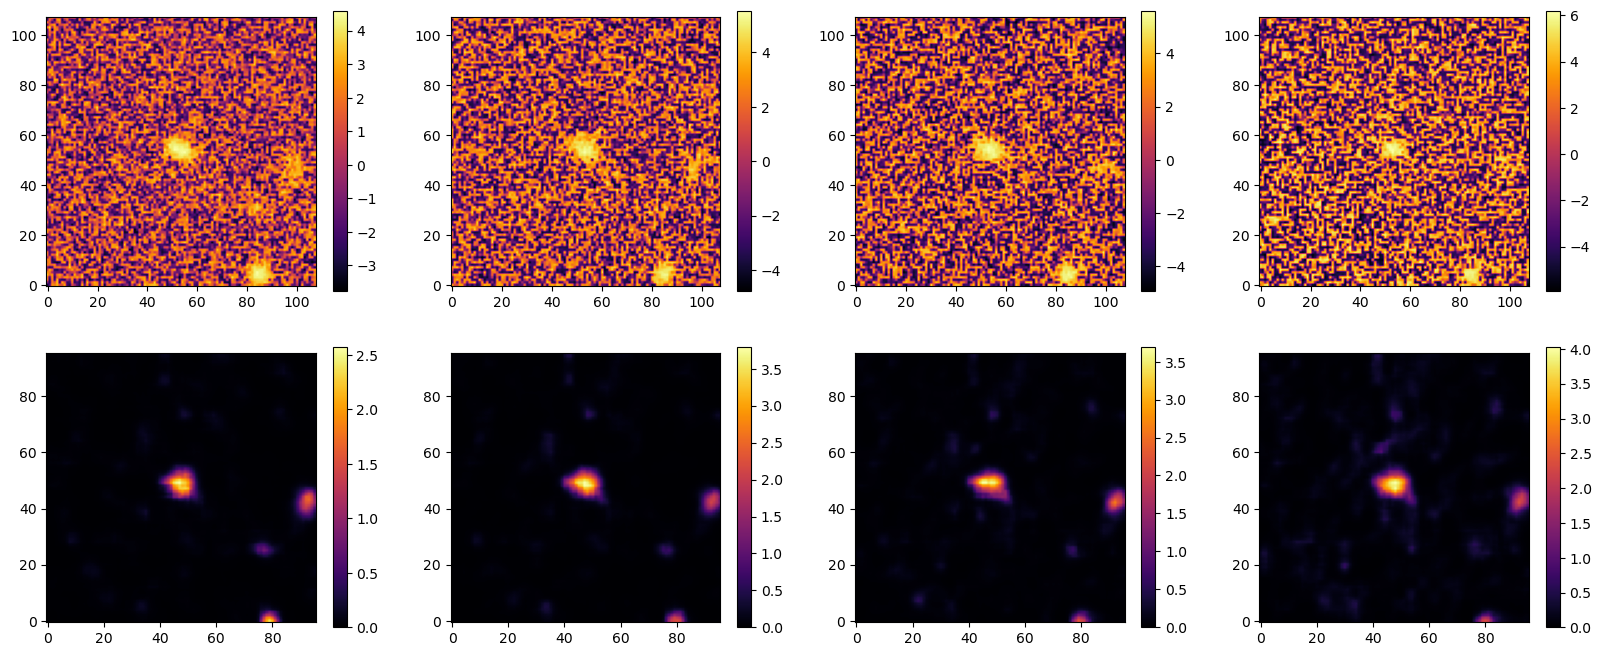

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,8))

for i in range(4):
    sd = ax[0,i].imshow(np.arcsinh(im[i,:,:]), origin='lower', cmap='inferno')
    fig.colorbar(sd, ax=ax[0,i])

    sd = ax[1,i].imshow(np.arcsinh(rec_im[0,i,:,:]), origin='lower', cmap='inferno')
    fig.colorbar(sd, ax=ax[1,i])

In [9]:
from aion.model import AION

# Disable gradients for this notebook
torch.set_grad_enabled(False)

# Importing model
model = AION.from_pretrained("polymathic-ai/aion-base").to("cuda").eval()


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /polymathic-ai/aion-base/resolve/main/config.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1bd43c0670>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: db6cbfab-3c14-4267-820c-c0370f51c8ed)')' thrown while requesting HEAD https://huggingface.co/polymathic-ai/aion-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /polymathic-ai/aion-base/resolve/main/config.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1bd43c08b0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 96392926-012b-492d-b87c-882f6e38ca92)')' thrown while requesting HEAD https://huggingface.co/polymathic-ai/aion-base/resolve/main/config.json
Retrying i

In [10]:
pred = model.encode(tokens, num_encoder_tokens=600)

In [11]:
ims = torch.tensor(test_file['images'][:,1:5,:,:].astype('float32')).to("cuda")
images = LegacySurveyImage(flux=ims, bands=["DES-G", "DES-R", "DES-I", "DES-Z"])

In [12]:
# Instantiate the manager
codec_manager = CodecManager(device="cuda")
batch_size = 32
n = ims.shape[0]
im_embeddings = []
for i in tqdm(range(0, n, batch_size)):
    images = LegacySurveyImage(flux=ims[i : min(n,i+batch_size)], bands=["DES-G", "DES-R", "DES-I", "DES-Z"])
    im_embeddings.append(
        model.encode(codec_manager.encode(images), num_encoder_tokens=600).mean(axis=1)
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:14<00:00,  6.28it/s]


In [13]:
im_embeddings = torch.cat(im_embeddings, dim=0).cpu().numpy()


In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(im_embeddings)
embedding.shape


In [ ]:
fig, ax = plt.subplots()

sd = ax.scatter(embedding[:,0], embedding[:,1], s=3, c=test_file['redshifts'][:], vmin=0, vmax=2)
fig.colorbar(sd, ax=ax)


In [ ]:
test_file['redshifts'][:]

In [ ]:
model = AION.from_pretrained("polymathic-ai/aion-base").to("cuda")

In [ ]:
from peft import LoraConfig, get_peft_model
# Helper function to count trainable parameters
def print_trainable_parameters(model):
    """Count and display trainable vs total parameters."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    
    trainable_pct = 100 * trainable_params / all_param
    print(f"  Trainable params: {trainable_params:,}")
    print(f"  Total params: {all_param:,}")
    print(f"  Trainable: {trainable_pct:.2f}%")

# Configure LoRA
lora_config = LoraConfig(
    r=40,                              # Rank (lower = fewer params)
    lora_alpha=32,                    # Scaling factor
    target_modules=["q", "proj"], # Adapt attention layers
    lora_dropout=0.1,                 # Regularization
    bias="none",                      # Don't adapt bias terms
)

# Apply LoRA to the model
print("🔄 Applying LoRA adapters to model...\n")
ft_model = get_peft_model(model, lora_config)

print("📊 Model Parameters Comparison:")
print("-" * 60)
print("Before LoRA (original model):")
print_trainable_parameters(model)
print("\nAfter LoRA (adapted model):")
print_trainable_parameters(ft_model)
print("-" * 60)
print("\n✓ LoRA adapters applied successfully!")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

In [ ]:
# Custom PyTorch Dataset for protein sequences
class SequenceDataset(Dataset):
    """
    Dataset class that tokenizes protein sequences on-the-fly.
    """
    def __init__(self, df, max_length=512):
        self.df = df
        self.max_length = max_length

    def __len__(self):
        return len(self.df[0]['tok_image'])

    def __getitem__(self, idx):
        inputs = {k: v[idx] for k, v in self.df[0].items()}

        return inputs, self.df[1][idx]

print("✓ SequenceDataset class defined")

In [ ]:
data =codec_manager.encode(LegacySurveyImage(flux=ims, bands=["DES-G", "DES-R", "DES-I", "DES-Z"]))

In [ ]:
data

In [ ]:
test_file.keys()

In [ ]:
data_numpy = {}
for key in data.keys():
    data_numpy[key]=np.array(data[key].cpu())
labels = test_file['redshifts'][:]

In [ ]:
sequence = SequenceDataset([data_numpy , labels.astype(np.float32)])

In [ ]:
data_numpy['tok_image'].shape

In [ ]:
ims.shape

In [ ]:
# Configuration
NSAMPLES = int(2000)  # Samples per split
SEED = 42

# Create random splits
rng = np.random.default_rng(SEED)
random_idxs = rng.choice(len(sequence), len(sequence), replace=False)

train_df = SequenceDataset(sequence[random_idxs[:NSAMPLES]])
val_df = SequenceDataset(sequence[random_idxs[NSAMPLES:int(1.1*NSAMPLES)]])
test_df = SequenceDataset(sequence[random_idxs[int(1.1*NSAMPLES):int(1.2*NSAMPLES)]])

print("✓ Data split created:")
print(f"  Train set: {len(train_df):,} samples")
print(f"  Validation set: {len(val_df):,} samples")
print(f"  Test set: {len(test_df):,} samples")

In [ ]:
device='cuda'
# Training configuration
BATCH_SIZE = 1000
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_WORKERS=12

# Create custom model with regression head
class RegressionModel(nn.Module):
    """Combines LoRA-adapted ESM model with regression head."""
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model  # LoRA-wrapped model
        self.regressor = nn.Linear(768, 1)
    def forward(self, inputs):
        outputs = self.base_model.encode(inputs, num_encoder_tokens=900).mean(axis=1)
        pooled_output = outputs
        return self.regressor(pooled_output).squeeze(-1)

# Instantiate the complete model
regression_model = RegressionModel(ft_model).to(device)

print("🎯 Complete Model Architecture:")
print("-" * 60)
print_trainable_parameters(regression_model)
print("-" * 60)

# Create data loaders
tokenizer = codec_manager.encode
train_dataset = train_df
val_dataset = val_df
test_dataset = test_df

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Setup optimizer and loss
optimizer = AdamW(filter(lambda p: p.requires_grad, regression_model.parameters()), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

print("\n✓ Model and data loaders ready for training!")

In [ ]:
torch.set_grad_enabled(True)
NUM_EPOCHS=10
# print("=" * 70)
print("🚀 STARTING LORA FINE-TUNING")
print("=" * 70)
print(f"Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Optimizer: AdamW")
print("=" * 70 + "\n")

for ep in range(NUM_EPOCHS):
    # Training phase
    regression_model.train()
    train_loss_sum = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{NUM_EPOCHS} [Train]", leave=False)
    for inputs, labels in pbar:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = regression_model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f"Epoch {ep+1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f}")

print("\n" + "=" * 70)
print("✓ Fine-tuning complete!")
print("=" * 70)